# **Laboratorio 5 - Inteligencia Artificial**


## **Integrantes del Grupo**

**Andy Fuentes 22944**

**Diederich Solís 22952**

**Davis Roldán 22672**

**Christian 221441**


# Task 1.1 - Graph-Search

Deberá construir un programa que reciba como entrada una imagen cuadrada que representa un laberinto (en formato **png** o **bmp**).  
Con dicha imagen, deberá dibujar en pantalla la solución al mismo. Además, deberá considerar las siguientes restricciones:

- **Las dimensiones de entrada podrán variar entre ejecuciones** (pero siempre será una imagen cuadrada).
- **Las áreas blancas representan caminos libres**.
- **Las áreas negras representan paredes** sobre las cuales no se puede pasar.
- **Las áreas verdes representan la meta** (_goalTest positivos_) _(pueden ser varios)_.
- **La área roja representa el punto de inicio** _(solo podrá haber uno)_.


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import deque
import heapq
from abc import ABC, abstractmethod

##############################
# Función para discretizar la imagen
##############################
def discretizar_imagen(nombre_archivo, cell_size=1, umbral=127, invertir_umbral=False):
    img = cv2.imread(nombre_archivo)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar '{nombre_archivo}'. Verifica que esté en el directorio.")

    rows = img.shape[0] // cell_size
    cols = img.shape[1] // cell_size
    grid = np.zeros((rows, cols), dtype=int)

    # Convenciones de colores:
    # Se usará ROJO (valor 3) para el INICIO y VERDE (valor 2) para la META.
    lower_red = np.array([0, 0, 150])
    upper_red = np.array([100, 100, 255])
    lower_green = np.array([0, 150, 0])
    upper_green = np.array([100, 255, 100])

    for i in range(rows):
        for j in range(cols):
            cell = img[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            mask_red = cv2.inRange(cell, lower_red, upper_red)
            mask_green = cv2.inRange(cell, lower_green, upper_green)
            red_count = cv2.countNonZero(mask_red)
            green_count = cv2.countNonZero(mask_green)

            if red_count > 0:
                grid[i, j] = 3   # Inicio
            elif green_count > 0:
                grid[i, j] = 2   # Meta
            else:
                cell_gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
                val = np.mean(cell_gray)
                if not invertir_umbral:
                    grid[i, j] = 1 if val > umbral else 0
                else:
                    grid[i, j] = 1 if val < umbral else 0

    return img, grid

# Task 1.2 - Framework de Problemas
Use una interfaz genérica (o clase abstracta) que sirva para representar el framework para definir el problema formal.
La implementación de la interfaz para este proyecto deberá recibir como parámetro de construcción la matriz
obtenida en el Task 1.1, y con esta deberá deducir las demás funciones del framework (actions(s), stepCost(s,a,s’),
etcétera). Debe utilizar efectivamente los conceptos del paradigma de POO.

In [31]:
##############################
# Framework de Problemas (POO)
##############################
class Problem(ABC):
    @abstractmethod
    def initial_state(self):
        pass

    @abstractmethod
    def actions(self, state):
        pass

    @abstractmethod
    def result(self, state, action):
        pass

    @abstractmethod
    def goal_test(self, state):
        pass

    @abstractmethod
    def step_cost(self, state, action, next_state):
        pass

class LaberintoProblem(Problem):
    def __init__(self, grid):
        self.grid = grid
        self.rows, self.cols = grid.shape
        self.start = None
        self.goals = []
        for r in range(self.rows):
            for c in range(self.cols):
                # Convención: ROJO (3) es inicio y VERDE (2) es meta
                if self.grid[r, c] == 3:
                    self.start = (r, c)
                elif self.grid[r, c] == 2:
                    self.goals.append((r, c))
        if self.start is None:
            raise ValueError("No se encontró celda de inicio (valor 3).")
        if not self.goals:
            raise ValueError("No se encontraron celdas meta (valor 2).")

    def initial_state(self):
        return self.start

    def actions(self, state):
        r, c = state
        acciones = []
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < self.rows and 0 <= nc < self.cols and self.grid[nr, nc] != 0:
                acciones.append((dr, dc))
        return acciones

    def result(self, state, action):
        r, c = state
        dr, dc = action
        return (r + dr, c + dc)

    def goal_test(self, state):
        return state in self.goals

    def step_cost(self, state, action, next_state):
        return 1


# Task 1.3 - Graph-Search
Deberá construir el algoritmo genérico (familia= de graphSearch. Este recibirá de parámetro una instancia del
framework de problemas. Sobre esta familia genérica, implemente los siguientes algoritmos:

- Breadth First Search (BFS)
- Depth First Search (DFS)
- A*: escoja dos heurísticas distintas, y justifique su selección.

In [32]:
##############################
# Algoritmos de búsqueda
##############################
class Node:
    def __init__(self, state, parent=None, action=None, cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost
    def __lt__(self, other):
        return self.cost < other.cost

def reconstruir_camino(node):
    camino = []
    while node is not None:
        camino.append(node.state)
        node = node.parent
    return list(reversed(camino))

def breadth_first_search(problem):
    start_node = Node(problem.initial_state())
    if problem.goal_test(start_node.state):
        return reconstruir_camino(start_node)
    frontier = deque([start_node])
    explored = {start_node.state}
    while frontier:
        node = frontier.popleft()
        for action in problem.actions(node.state):
            child_state = problem.result(node.state, action)
            if child_state not in explored:
                child_node = Node(child_state, node, action, node.cost + 1)
                if problem.goal_test(child_state):
                    return reconstruir_camino(child_node)
                frontier.append(child_node)
                explored.add(child_state)
    return None

def depth_first_search(problem):
    start_node = Node(problem.initial_state())
    if problem.goal_test(start_node.state):
        return reconstruir_camino(start_node)
    frontier = [start_node]
    explored = {start_node.state}
    while frontier:
        node = frontier.pop()
        for action in problem.actions(node.state):
            child_state = problem.result(node.state, action)
            if child_state not in explored:
                child_node = Node(child_state, node, action, node.cost + 1)
                if problem.goal_test(child_state):
                    return reconstruir_camino(child_node)
                frontier.append(child_node)
                explored.add(child_state)
    return None

def heuristic_manhattan(state, goals):
    r, c = state
    return min(abs(r - gr) + abs(c - gc) for (gr, gc) in goals)

def heuristic_euclidiana(state, goals):
    r, c = state
    return min(math.sqrt((r - gr)**2 + (c - gc)**2) for (gr, gc) in goals)

def a_star_search(problem, heuristic_func):
    start_node = Node(problem.initial_state())
    if problem.goal_test(start_node.state):
        return reconstruir_camino(start_node)
    start_h = heuristic_func(start_node.state, problem.goals)
    frontier = []
    heapq.heappush(frontier, (start_node.cost + start_h, start_node))
    explored = {start_node.state: start_node.cost}
    while frontier:
        _, current_node = heapq.heappop(frontier)
        if problem.goal_test(current_node.state):
            return reconstruir_camino(current_node)
        for action in problem.actions(current_node.state):
            child_state = problem.result(current_node.state, action)
            new_cost = current_node.cost + problem.step_cost(current_node.state, action, child_state)
            if child_state not in explored or new_cost < explored[child_state]:
                explored[child_state] = new_cost
                h = heuristic_func(child_state, problem.goals)
                child_node = Node(child_state, current_node, action, new_cost)
                heapq.heappush(frontier, (new_cost + h, child_node))
    return None

# Task 1.4 - Graph-Search

Resuelva el laberinto de entrada, y muestre en pantalla gráficamente el camino encontrado. Su representación visual
se basará en la matriz discreta, no en la imagen original.


--------------------------------------------------
Procesando imagen: Test.bmp


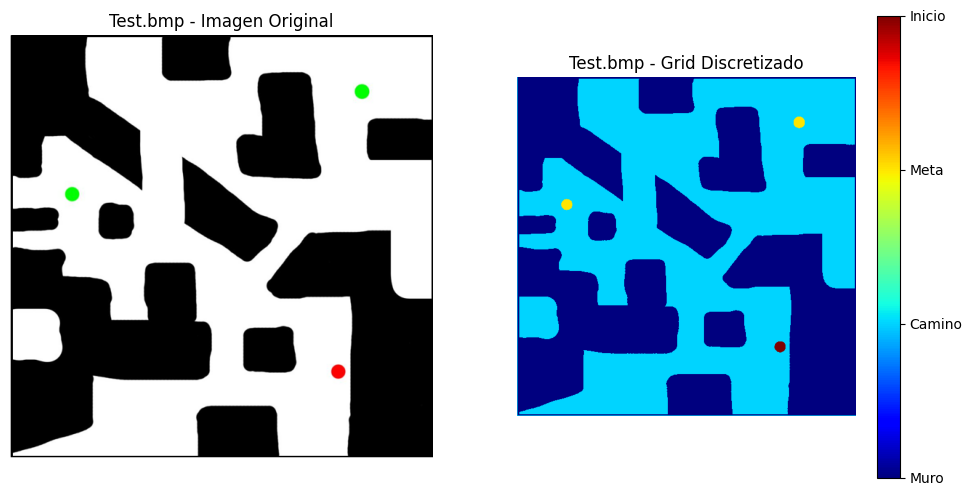

BFS: [(472, 453), (471, 453), (470, 453), (469, 453), (468, 453), (467, 453), (466, 453), (465, 453), (464, 453), (463, 453), (462, 453), (461, 453), (460, 453), (459, 453), (458, 453), (457, 453), (456, 453), (455, 453), (454, 453), (453, 453), (452, 453), (451, 453), (450, 453), (449, 453), (448, 453), (447, 453), (446, 453), (445, 453), (444, 453), (443, 453), (442, 453), (441, 453), (440, 453), (439, 453), (438, 453), (437, 453), (436, 453), (435, 453), (434, 453), (433, 453), (432, 453), (431, 453), (430, 453), (429, 453), (428, 453), (427, 453), (426, 453), (425, 453), (424, 453), (423, 453), (422, 453), (421, 453), (420, 453), (419, 453), (418, 453), (417, 453), (416, 453), (415, 453), (414, 453), (413, 453), (412, 453), (411, 453), (410, 453), (409, 453), (408, 453), (407, 453), (406, 453), (405, 453), (404, 453), (403, 453), (402, 453), (401, 453), (400, 453), (399, 453), (398, 453), (397, 453), (396, 453), (395, 453), (394, 453), (393, 453), (392, 453), (391, 453), (390, 453)

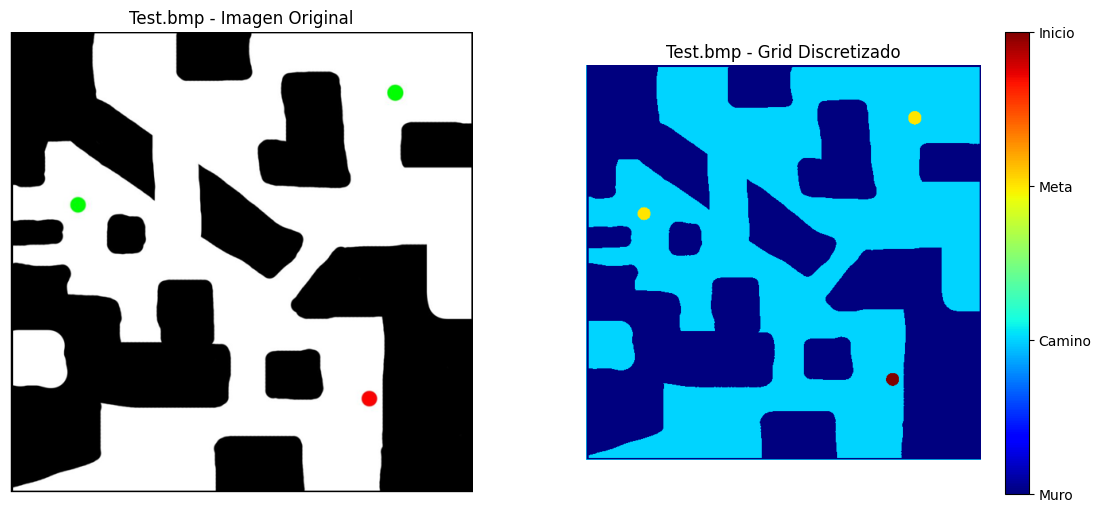

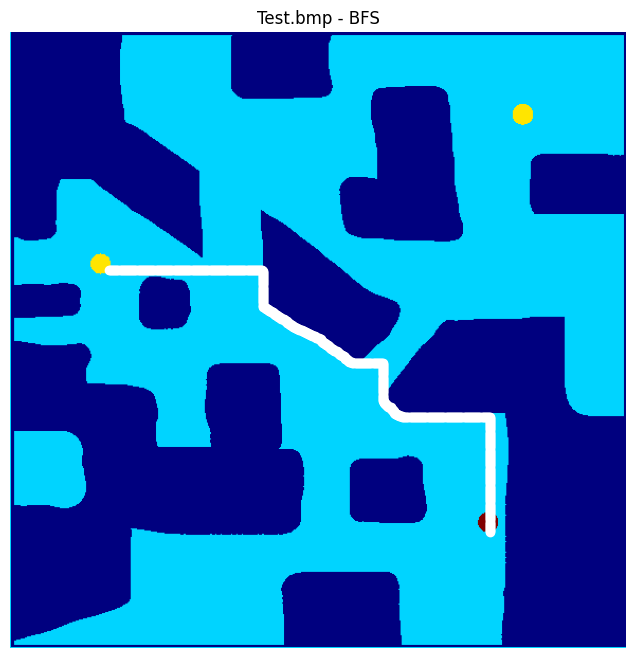

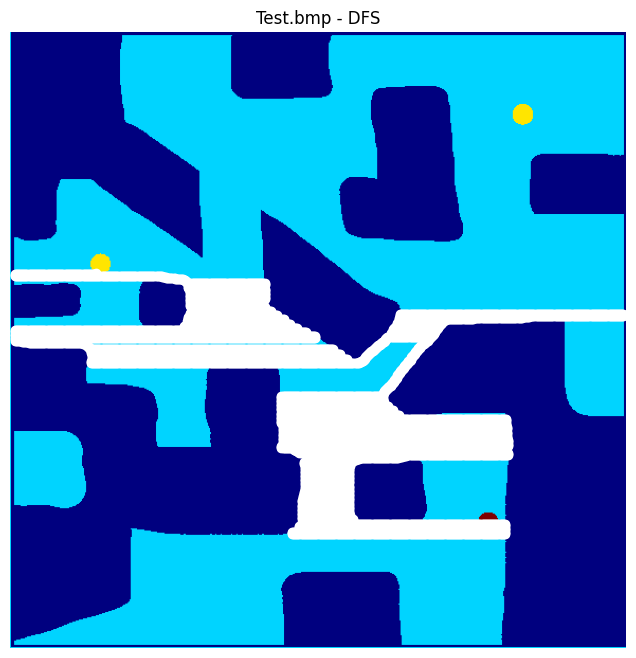

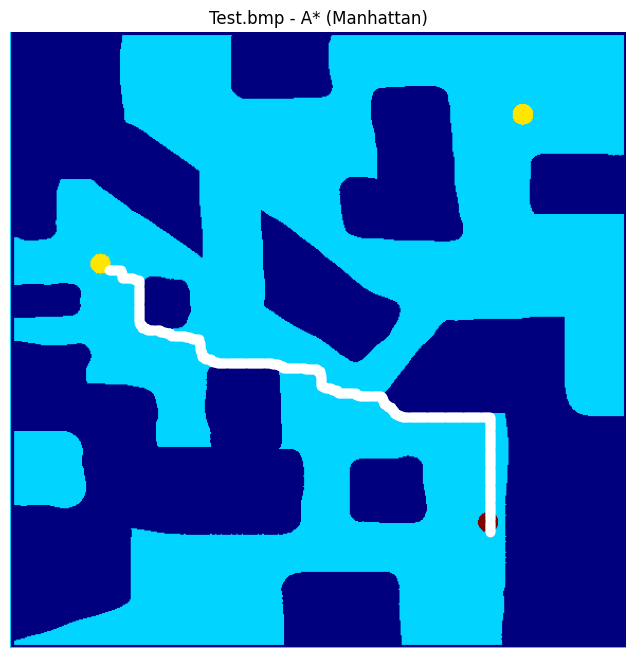

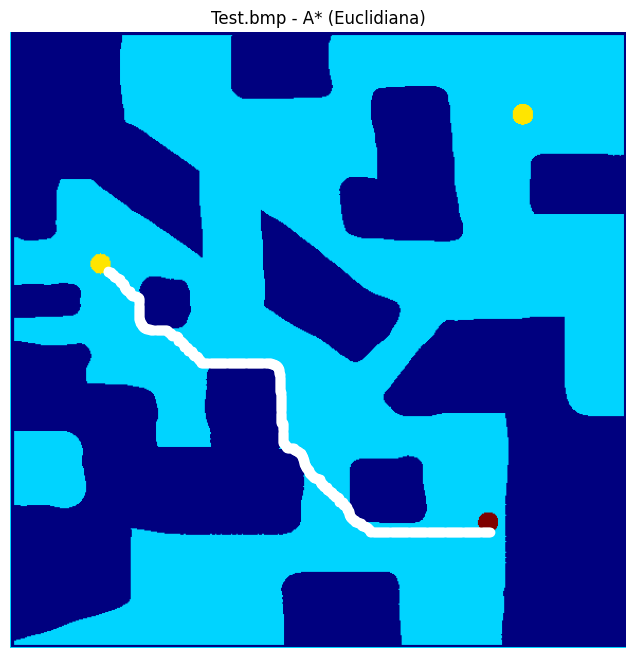


--------------------------------------------------
Procesando imagen: Test2.bmp


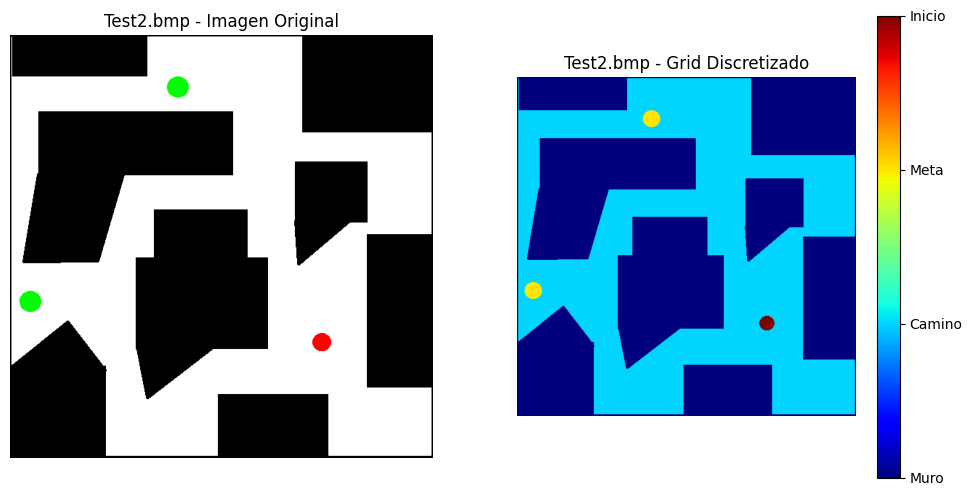

BFS: [(434, 432), (433, 432), (432, 432), (431, 432), (430, 432), (429, 432), (428, 432), (427, 432), (426, 432), (425, 432), (424, 432), (423, 432), (422, 432), (421, 432), (420, 432), (419, 432), (418, 432), (417, 432), (416, 432), (415, 432), (414, 432), (413, 432), (412, 432), (411, 432), (410, 432), (409, 432), (408, 432), (407, 432), (406, 432), (405, 432), (404, 432), (403, 432), (402, 432), (401, 432), (400, 432), (399, 432), (398, 432), (397, 432), (396, 432), (395, 432), (394, 432), (393, 432), (392, 432), (391, 432), (390, 432), (389, 432), (388, 432), (387, 432), (386, 432), (385, 432), (384, 432), (383, 432), (382, 432), (381, 432), (380, 432), (379, 432), (378, 432), (377, 432), (376, 432), (375, 432), (374, 432), (373, 432), (372, 432), (371, 432), (370, 432), (369, 432), (368, 432), (367, 432), (366, 432), (365, 432), (364, 432), (363, 432), (362, 432), (361, 432), (360, 432), (359, 432), (358, 432), (357, 432), (356, 432), (355, 432), (354, 432), (353, 432), (352, 432)

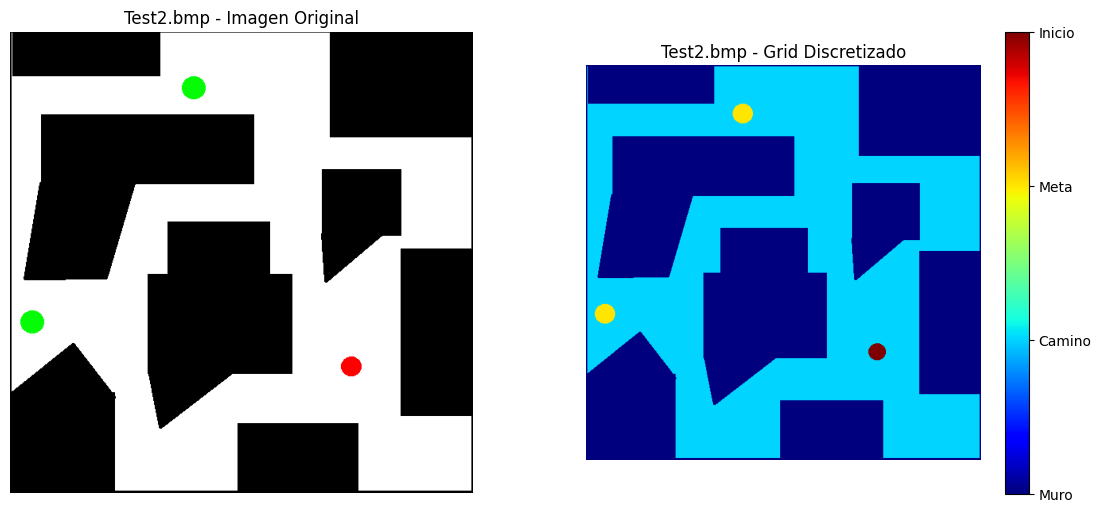

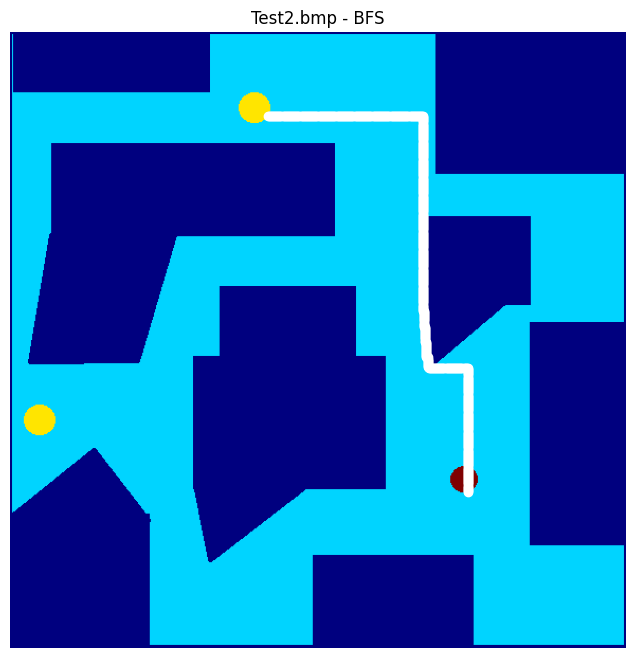

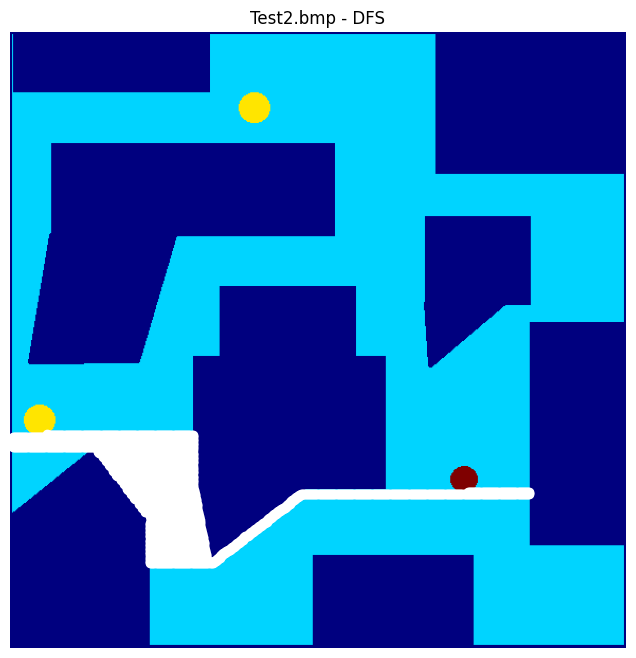

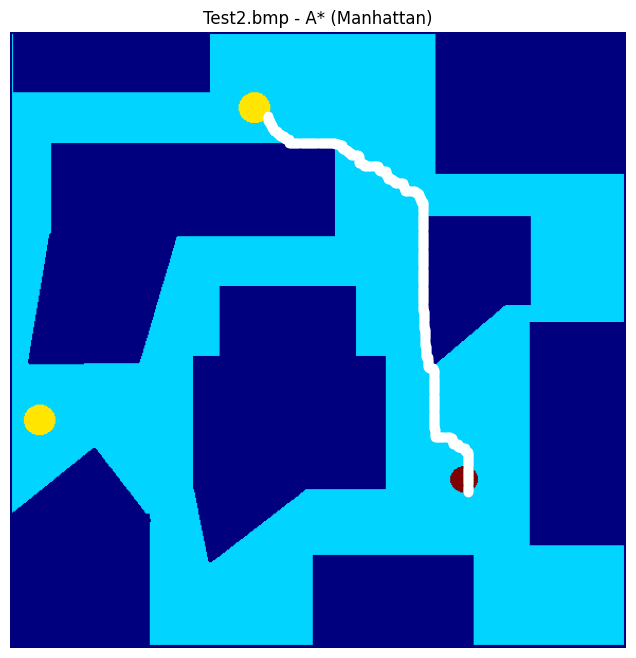

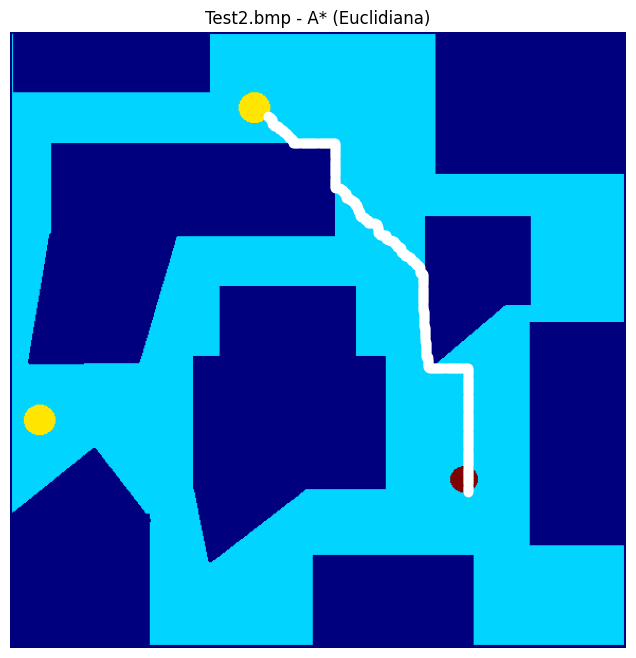


--------------------------------------------------
Procesando imagen: turing.bmp


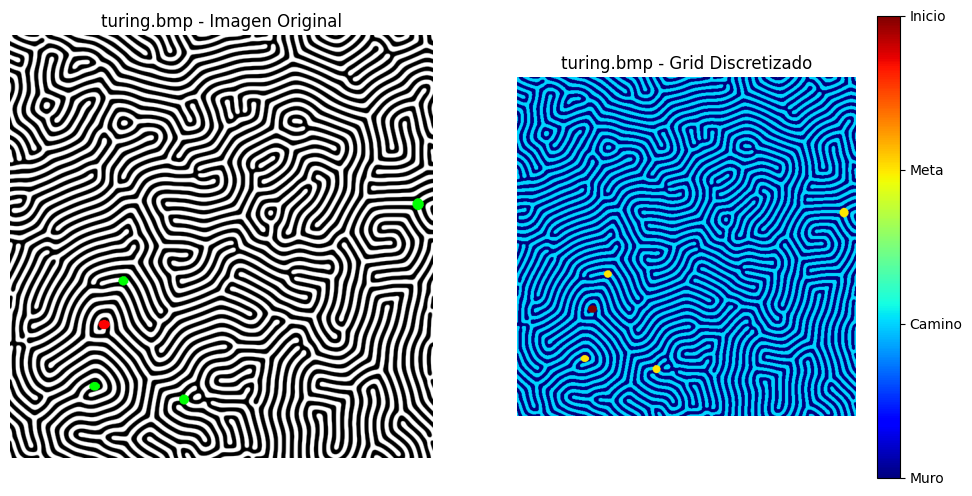

BFS: [(444, 145), (443, 145), (442, 145), (441, 145), (440, 145), (439, 145), (438, 145), (438, 146), (438, 147), (438, 148), (438, 149), (438, 150), (438, 151), (438, 152), (439, 152), (440, 152), (441, 152), (442, 152), (443, 152), (444, 152), (445, 152), (446, 152), (447, 152), (448, 152), (449, 152), (450, 152), (451, 152), (452, 152), (453, 152), (454, 152), (454, 153), (454, 154), (455, 154), (455, 155), (456, 155), (456, 156), (456, 157), (457, 157), (457, 158), (458, 158), (458, 159), (459, 159), (459, 160), (460, 160), (460, 161), (461, 161), (461, 162), (462, 162), (462, 163), (463, 163), (463, 164), (464, 164), (464, 165), (465, 165), (465, 166), (466, 166), (466, 167), (467, 167), (467, 168), (468, 168), (468, 169), (469, 169), (469, 170), (470, 170), (470, 171), (471, 171), (471, 172), (472, 172), (472, 173), (473, 173), (473, 174), (474, 174), (474, 175), (475, 175), (475, 176), (476, 176), (476, 177), (477, 177), (477, 178), (478, 178), (478, 179), (479, 179), (479, 180)

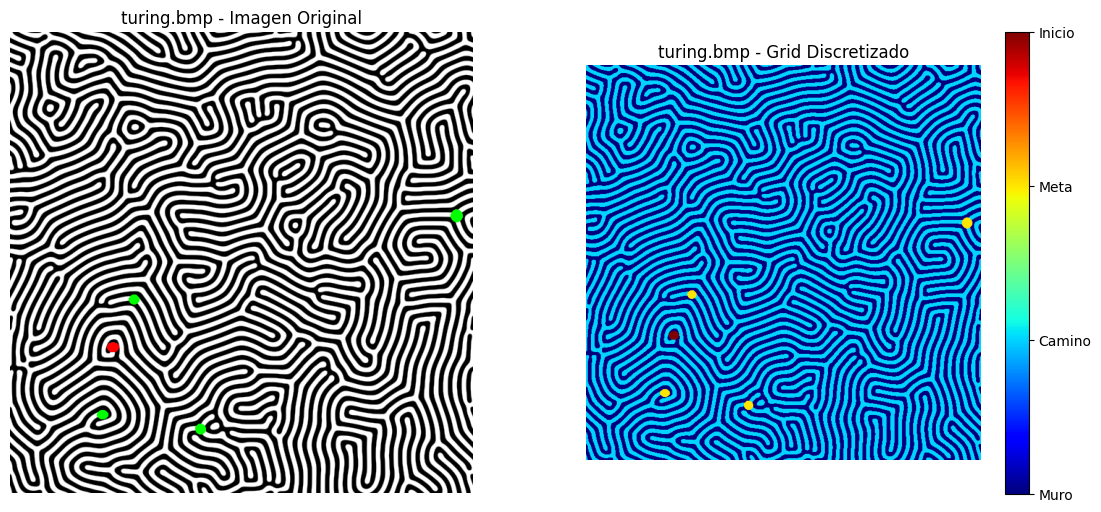

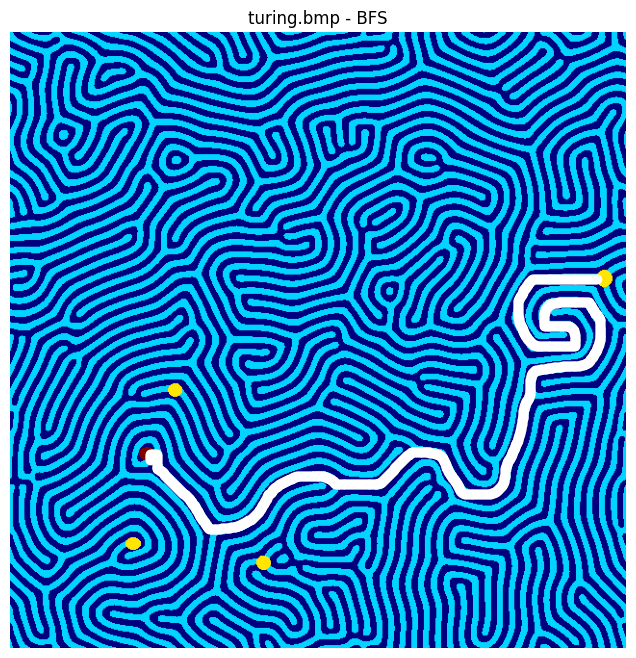

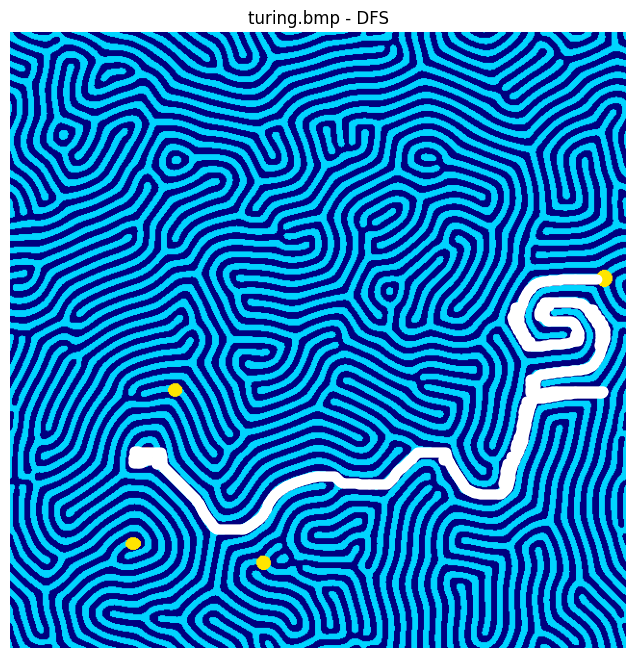

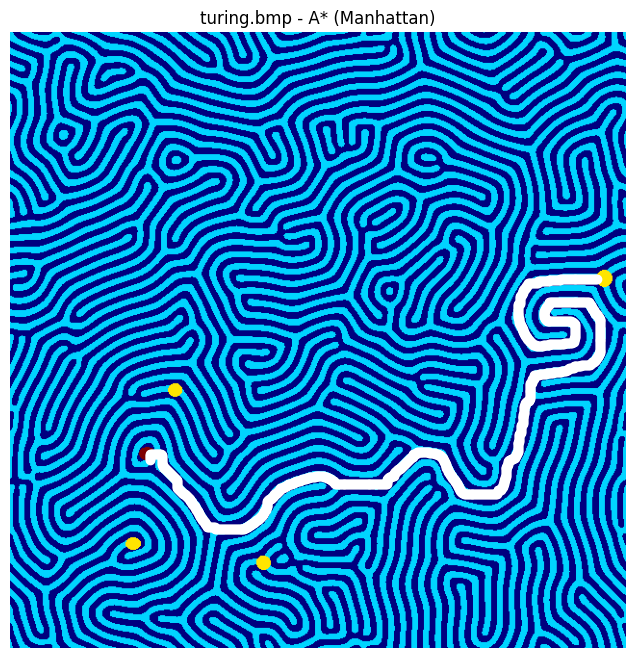

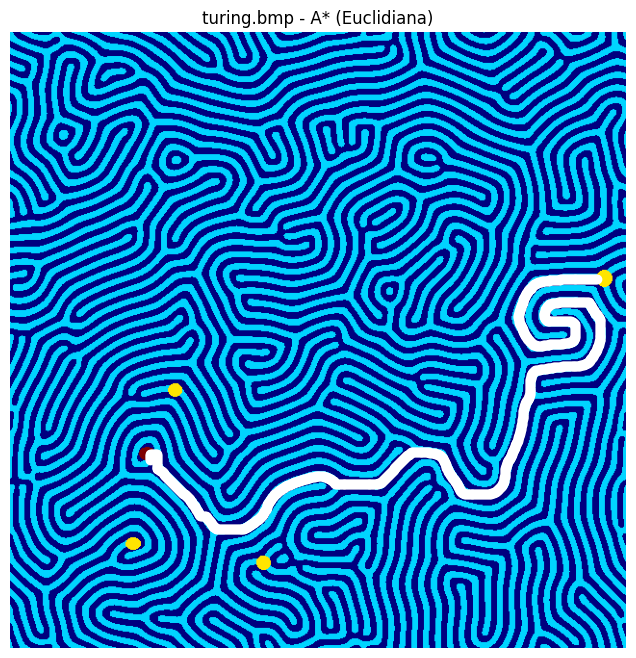

In [33]:
##############################
# Visualización de resultados
##############################
def mostrar_resultados(nombre, img, grid, camino_dict):
    # Mostrar imagen original y grid discretizado
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{nombre} - Imagen Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(grid, cmap="jet", origin="upper")
    plt.title(f"{nombre} - Grid Discretizado")
    cbar = plt.colorbar(ticks=[0,1,2,3])
    cbar.ax.set_yticklabels(["Muro", "Camino", "Meta", "Inicio"])
    plt.axis("off")
    plt.show()

    # Mostrar caminos encontrados con cada algoritmo
    for key, camino in camino_dict.items():
        plt.figure(figsize=(8,8))
        plt.imshow(grid, cmap="jet", origin="upper")
        if camino:
            xs = [s[1] for s in camino]
            ys = [s[0] for s in camino]
            plt.plot(xs, ys, marker="o", color="white", linewidth=2)
            plt.title(f"{nombre} - {key}")
        else:
            plt.title(f"{nombre} - {key} (No se encontró camino)")
        plt.axis("off")
        plt.show()

##############################
# Procesar las 3 imágenes
##############################
nombres = ["Test.bmp", "Test2.bmp", "turing.bmp"]

for nombre in nombres:
    print("\n--------------------------------------------------")
    print(f"Procesando imagen: {nombre}")
    try:
        # Discretización
        img, grid = discretizar_imagen(nombre, cell_size=1, umbral=127, invertir_umbral=False)

        # Mostrar imagen original y grid
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{nombre} - Imagen Original")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(grid, cmap="jet", origin="upper")
        plt.title(f"{nombre} - Grid Discretizado")
        cbar = plt.colorbar(ticks=[0,1,2,3])
        cbar.ax.set_yticklabels(["Muro", "Camino", "Meta", "Inicio"])
        plt.axis("off")
        plt.show()

        # Instanciar el problema
        problema = LaberintoProblem(grid)


        # Ejecutar algoritmos de búsqueda
        caminos = {}
        caminos["BFS"] = breadth_first_search(problema)
        caminos["DFS"] = depth_first_search(problema)
        caminos["A* (Manhattan)"] = a_star_search(problema, heuristic_manhattan)
        caminos["A* (Euclidiana)"] = a_star_search(problema, heuristic_euclidiana)

        # Imprimir caminos en consola
        for key, camino in caminos.items():
            print(f"{key}: {camino}")

        # Mostrar resultados de caminos de forma estilizada
        mostrar_resultados(nombre, img, grid, caminos)

    except Exception as e:
        print(f"Error procesando la imagen {nombre}: {e}")


# Justificación de las heurísticas y análisis de resultados

En la resolución del laberinto con **A\***, he elegido dos heurísticas diferentes: **Manhattan** y **Euclidiana**. Ambas me permiten estimar la distancia entre un estado y la meta, pero difieren en la forma en que calculan dicha distancia.



### 1. Heurística Manhattan

- **Justificación:**  
  - Es adecuada cuando solo se puede mover en 4 direcciones (arriba, abajo, izquierda, derecha).  
  - Al ser la distancia en “bloques” (en ejes x e y), nunca sobreestima el costo real de llegar a la meta, por lo que A* encuentra el camino óptimo.  
  - Suele ser sencilla de implementar y muy eficiente en laberintos tipo grid.  
  - Es **admisible**, ya que siempre subestima o iguala el costo real, lo que garantiza la optimalidad del camino encontrado.



### 2. Heurística Euclidiana

- **Justificación:**  
  - Ofrece una aproximación “geométrica” de la distancia, calculando la línea recta entre dos puntos.  
  - En un laberinto sin movimientos diagonales, puede subestimar ligeramente la distancia real, pero sigue siendo **admisible** (no sobreestima el costo real).  
  - Aunque puede guiar la búsqueda de forma diferente, en general, para grids con movimientos restringidos a 4 direcciones, la heurística **Manhattan** suele ajustarse mejor a la realidad de los pasos.  
  - Es útil en entornos donde los movimientos diagonales están permitidos, ya que refleja mejor la distancia real en esos casos.



## Análisis comparativo (Test.bmp)

En la práctica, tanto **A\* con Manhattan** como **A\* con Euclidiana** encuentran la misma ruta óptima en este laberinto, ya que ambas son heurísticas admisibles. Sin embargo, existen diferencias clave en su comportamiento:

- **A\* con Manhattan**:  
  - Para desplazamientos estrictamente en 4 direcciones, esta heurística suele correlacionarse mejor con el costo real (camino en ejes x e y).  
  - En algunos casos, explora menos nodos que la heurística Euclidiana, lo que la hace más eficiente en términos de tiempo y memoria.  

- **A\* con Euclidiana**:  
  - Aunque también es admisible, en grids con movimientos restringidos a 4 direcciones, puede no ser tan precisa como Manhattan.  
  - En entornos con movimientos diagonales, esta heurística sería más adecuada, ya que refleja mejor la distancia real.  

- **BFS (Búsqueda en Anchura)**:  
  - Garantiza el camino óptimo, pero explora más nodos que A*, ya que no prioriza un rumbo hacia la meta.  
  - Es menos eficiente en términos de memoria, especialmente en laberintos grandes.  

- **DFS (Búsqueda en Profundidad)**:  
  - No garantiza encontrar el camino más corto, ya que puede recorrer grandes secciones del laberinto sin llegar a la meta de forma eficiente.  
  - Es más eficiente en términos de memoria, pero no es adecuado cuando se requiere el camino óptimo.  


### Conclusiones

- **Heurística de Manhattan**: Es la más adecuada para laberintos con movimientos restringidos a 4 direcciones, ya que es admisible, sencilla de implementar y suele ser más eficiente en términos de nodos explorados.  
- **Heurística Euclidiana**: Es útil en entornos con movimientos diagonales, pero en grids 4-direcciones, puede no ser tan precisa como Manhattan.  
- **A\***: Ofrece un equilibrio entre eficiencia y optimalidad, dependiendo de la heurística utilizada.  
- **BFS**: Garantiza el camino óptimo, pero es menos eficiente en términos de memoria.  
- **DFS**: No garantiza el camino óptimo y puede ser ineficiente en laberintos grandes.  
